In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

In [5]:
imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)

imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=ExtraTreesRegressor(), random_state=42)

In [6]:
# replace NA
X_train_bayes = imputer_bayes.transform(X_train)
X_test_bayes = imputer_bayes.transform(X_test)

X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

X_train_nonLin = imputer_nonLin.transform(X_train)
X_test_nonLin = imputer_nonLin.transform(X_test)

X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

In [7]:
X_train_bayes_t = pd.DataFrame(X_train_bayes, columns=X_train.columns)
X_test_bayes_t = pd.DataFrame(X_test_bayes, columns=X_test.columns)

X_train_knn_t = pd.DataFrame(X_train_knn, columns=X_train.columns)
X_test_knn_t = pd.DataFrame(X_test_knn, columns=X_test.columns)

X_train_nonLin_t = pd.DataFrame(X_train_nonLin, columns=X_train.columns)
X_test_nonLin_t = pd.DataFrame(X_test_nonLin, columns=X_test.columns)

X_train_missForest_t = pd.DataFrame(X_train_missForest, columns=X_train.columns)
X_test_missForest_t = pd.DataFrame(X_test_missForest, columns=X_test.columns)

In [8]:
dataframes = [
    X_train_bayes_t, X_test_bayes_t, 
    X_train_knn_t, X_test_knn_t,
    X_train_nonLin_t, X_test_nonLin_t,
    X_train_missForest_t, X_test_missForest_t,
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


### Stratified Cross-Validation


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score, make_scorer
import numpy as np

def run_random_forest(classifier_name, imp_method, X_train, y_train):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        metrics = {"accuracy": make_scorer(accuracy_score),
                   "balanced_accuracy": make_scorer(balanced_accuracy_score),  
                   "precision": make_scorer(precision_score, average="weighted", zero_division=0), 
                   "recall": make_scorer(recall_score, average="weighted", zero_division=0), 
                   "f1_weighted": make_scorer(f1_score, average="weighted", zero_division=0),
                   "roc_auc_ovr_weighted": make_scorer(roc_auc_score, 
                                                       average="weighted", 
                                                       multi_class="ovr", 
                                                       response_method="predict_proba",),
        }
        
        cross_val_results = cross_validate(rf,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring=metrics,
                                           return_train_score=True,
        )
                
        metric_names = list(metrics.keys())
        mean_train = [round(np.mean(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        std_train = [round(np.std(cross_val_results[f"train_{metric}"]), 3) for metric in metric_names]
        mean_test = [round(np.mean(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        std_test = [round(np.std(cross_val_results[f"test_{metric}"]), 3) for metric in metric_names]
        time = round(np.mean(cross_val_results[f"fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Fit Time": time,
                "Metric": metric_names,
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = rf.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [10]:
bayes_model, bayes_metrics = run_random_forest("Random Forest", "Ridge Bayes", X_train_bayes_t, y_train)
knn_model, knn_metrics = run_random_forest("Random Forest", "KNN Reg", X_train_knn_t, y_train)
nonLin_model, nonLin_metrics = run_random_forest("Random Forest", "NonLin", X_train_nonLin_t, y_train)
missForest_model, missForest_metrics = run_random_forest("Random Forest", "MissForest", X_train_missForest_t, y_train)

In [11]:
validation_df = pd.concat([bayes_metrics, knn_metrics, nonLin_metrics, missForest_metrics])
validation_df_report = validation_df.set_index(["Classifier", "Imputation", "Fit Time", "Metric"])
validation_df_report

Mean Train  \
Classifier    Imputation  Fit Time Metric                             
Random Forest Ridge Bayes 0.474    accuracy                   0.805   
                                   balanced_accuracy          0.808   
                                   precision                  0.825   
                                   recall                     0.805   
                                   f1_weighted                0.811   
                                   roc_auc_ovr_weighted       0.953   
              KNN Reg     0.413    accuracy                   0.801   
                                   balanced_accuracy          0.804   
                                   precision                  0.823   
                                   recall                     0.801   
                                   f1_weighted                0.806   
                                   roc_auc_ovr_weighted       0.952   
              NonLin      0.497    accuracy                   0.808   
                                   balanced_accuracy          0.809   
                                   precision                  0.827   
                                   recall                     0.808   
                                   f1_weighted                0.813   
                                   roc_auc_ovr_weighted       0.953   
              MissForest  0.388    accuracy                   0.806   
                                   balanced_accuracy          0.807   
                                   precision                  0.825   
                                   recall                     0.806   
                                   f1_weighted                0.811   
                                   roc_auc_ovr_weighted       0.953   

                                                         Std Train  Mean Test  \
Classifier    Imputation  Fit Time Metric                                       
Random Forest Ridge Bayes 0.474    accuracy                  0.006      0.710   
                                   balanced_accuracy         0.006      0.686   
                                   precision                 0.005      0.734   
                                   recall                    0.006      0.710   
                                   f1_weighted               0.006      0.716   
                                   roc_auc_ovr_weighted      0.001      0.879   
              KNN Reg     0.413    accuracy                  0.005      0.706   
                                   balanced_accuracy         0.006      0.683   
                                   precision                 0.005      0.733   
                                   recall                    0.005      0.706   
                                   f1_weighted               0.005      0.714   
                                   roc_auc_ovr_weighted      0.002      0.875   
              NonLin      0.497    accuracy                  0.006      0.720   
                                   balanced_accuracy         0.006      0.693   
                                   precision                 0.004      0.740   
                                   recall                    0.006      0.720   
                                   f1_weighted               0.005      0.726   
                                   roc_auc_ovr_weighted      0.001      0.878   
              MissForest  0.388    accuracy                  0.007      0.710   
                                   balanced_accuracy         0.006      0.682   
                                   precision                 0.004      0.733   
                                   recall                    0.007      0.710   
                                   f1_weighted               0.006      0.716   
                                   roc_auc_ovr_weighted      0.001      0.879   

                                                         Std Test  
Classifier    Imputation  Fit Time 

C:\Users\steve\AppData\Local\Temp\ipykernel_21484\265476517.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


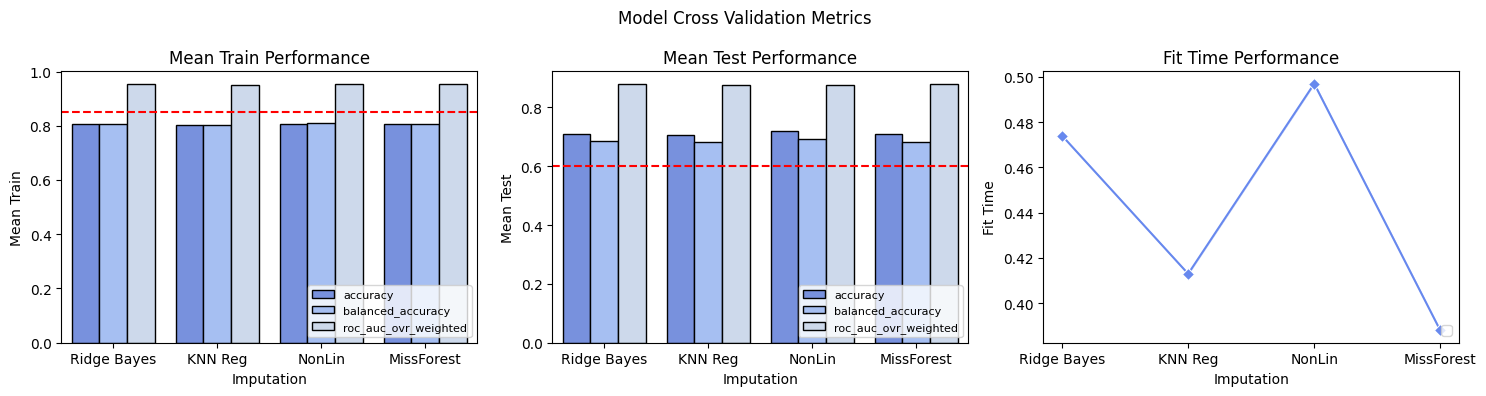

In [12]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_validation = validation_df[validation_df['Metric'].isin(metrics_to_plot)]
filtered_df_validation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Validation Metrics")
sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Train', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower right",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Mean Train Performance")

sns.barplot(data=filtered_df_validation, x='Imputation', y='Mean Test', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower right",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Mean Test Performance")

sns.lineplot(data=filtered_df_validation, x='Imputation', y=filtered_df_validation['Fit Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()

### Evaluate

In [13]:
import time

def eval_random_forest(classifier_name, imp_method, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"), 3),
        }

        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Classifier": classifier_name,
                "Imputation": imp_method,
                "Classification Time": round(elapsed_time, 3),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [14]:
pred_bayes = eval_random_forest("Random Forest", "Ridge Bayes", bayes_model, X_train_bayes_t, X_test_bayes_t, y_train, y_test)
pred_knn = eval_random_forest("Random Forest", "KNN Reg", knn_model, X_train_knn_t, X_test_knn_t, y_train, y_test)
pred_nonLin = eval_random_forest("Random Forest", "NonLin", nonLin_model, X_train_nonLin_t, X_test_nonLin_t, y_train, y_test)
pred_missForest = eval_random_forest("Random Forest", "MissForest", missForest_model, X_train_missForest_t, X_test_missForest_t, y_train, y_test)

In [15]:
prediction_df = pd.concat([pred_bayes, pred_knn, pred_nonLin, pred_missForest])
prediction_df_report = prediction_df.set_index(["Classifier", "Imputation",	"Classification Time", "Metric"])
prediction_df_report

Train data  \
Classifier    Imputation  Classification Time Metric                             
Random Forest Ridge Bayes 0.135               accuracy                   0.804   
                                              balanced_accuracy          0.806   
                                              precision                  0.822   
                                              recall                     0.804   
                                              f1_weighted                0.809   
                                              roc_auc_ovr_weighted       0.950   
              KNN Reg     0.102               accuracy                   0.787   
                                              balanced_accuracy          0.790   
                                              precision                  0.811   
                                              recall                     0.787   
                                              f1_weighted                0.794   
                                              roc_auc_ovr_weighted       0.947   
              NonLin      0.108               accuracy                   0.799   
                                              balanced_accuracy          0.797   
                                              precision                  0.818   
                                              recall                     0.799   
                                              f1_weighted                0.804   
                                              roc_auc_ovr_weighted       0.949   
              MissForest  0.090               accuracy                   0.810   
                                              balanced_accuracy          0.808   
                                              precision                  0.826   
                                              recall                     0.810   
                                              f1_weighted                0.815   
                                              roc_auc_ovr_weighted       0.950   

                                                                    Test data  
Classifier    Imputation  Classification Time Metric                           
Random Forest Ridge Bayes 0.135               accuracy                  0.748  
                                              balanced_accuracy         0.727  
                                              precision                 0.776  
                                              recall                    0.748  
                                              f1_weighted               0.756  
                                              roc_auc_ovr_weighted      0.897  
              KNN Reg     0.102               accuracy                  0.743  
                                              balanced_accuracy         0.730  
                                              precision                 0.774  
                                              recall                    0.743  
                                              f1_weighted               0.751  
                                              roc_auc_ovr_weighted      0.898  
              NonLin      0.108               accuracy                  0.759  
                                              balanced_accuracy         0.745  
                                              precision                 0.787  
                                              recall                    0.759  
                                              f1_weighted               0.767  
                                              roc_auc_ovr_weighted      0.900  
              MissForest  0.090               accuracy                  0.756  
                                              balanced_accuracy         0.730  
                                              precision                 0.781  
                                              recall                    0.756  
               

C:\Users\steve\AppData\Local\Temp\ipykernel_21484\169164776.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend(loc="lower right")


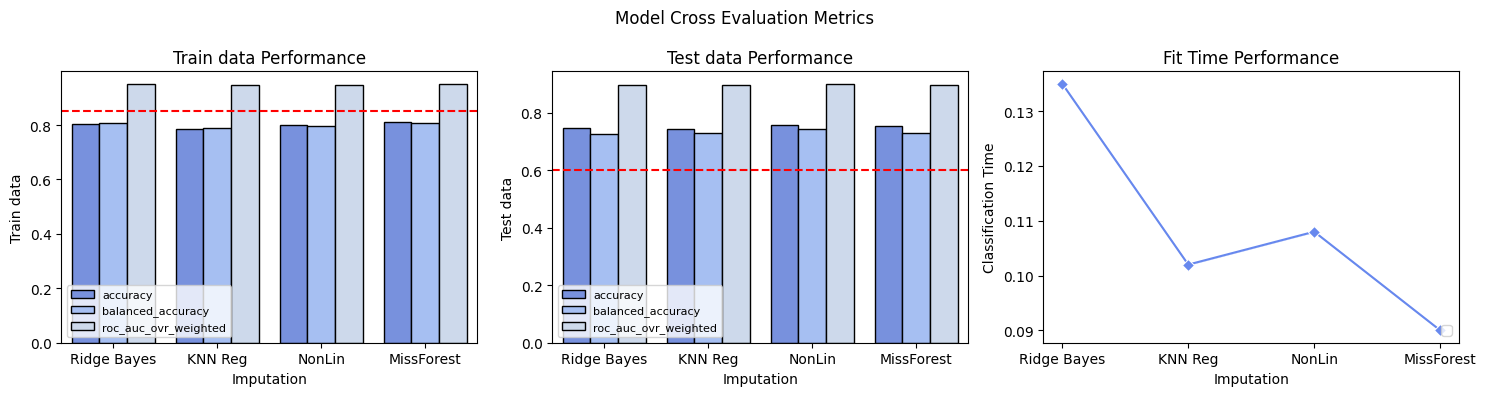

In [16]:
# Filter the metrics you want to plot (Fit Time, Accuracy, Balanced Accuracy, ROC AUC)
metrics_to_plot = ['accuracy', 'balanced_accuracy', 'roc_auc_ovr_weighted']
filtered_df_evaluation = prediction_df[prediction_df['Metric'].isin(metrics_to_plot)]
filtered_df_evaluation

sns.set_palette("coolwarm")
fig, axs = plt.subplots(1,3, figsize = (15, 4))

plt.suptitle("Model Cross Evaluation Metrics")
sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Train data', hue='Metric', edgecolor='black', ax = axs[0])
axs[0].legend(loc="lower left",  fontsize=8)
axs[0].axhline(y=0.85, color='red', linestyle='--', linewidth=1.5) 
axs[0].set_title("Train data Performance")

sns.barplot(data=filtered_df_evaluation, x='Imputation', y='Test data', hue='Metric', edgecolor='black', ax = axs[1])
axs[1].legend(loc="lower left",  fontsize=8)
axs[1].axhline(y=0.60, color="red", linestyle="--", linewidth=1.5)
axs[1].set_title("Test data Performance")

sns.lineplot(data=filtered_df_evaluation, x='Imputation', y=filtered_df_evaluation['Classification Time'], marker="D", ax = axs[2])
axs[2].legend(loc="lower right")
axs[2].set_title("Fit Time Performance")

plt.tight_layout()